![alt text](https://drive.google.com/uc?export=view&id=1UXScsVx_Wni_JuDdB8LeTnM6jsPfIwkW)

## Model Building for Pneumonia Detection - EfficientDet

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


References 
1. Original paper: https://arxiv.org/pdf/1911.09070.pdf
2. Repository clone: !git clone https://github.com/kamauz/EfficientDet.git


#### import libraries

In [ ]:
import numpy as np 
import pandas as pd
import os
import sys
import json
import cv2
import time
import glob
from PIL import Image
from skimage.transform import resize
import tensorflow as tf
import keras
from tensorflow.keras.optimizers import Adam


# Suppress warnings, if any
import warnings; warnings.filterwarnings('ignore')

# Print versions
print(f'Pandas version: {pd.__version__}')
print(f'Numpy version: {np.__version__}')
print(f'keras version: {keras.__version__}')
print(f'Tensorflow version: {tf.__version__}')
print(f'CV version: {cv2.__version__}')

Pandas version: 1.1.5
Numpy version: 1.19.5
keras version: 2.2.5
Tensorflow version: 1.15.0
CV version: 3.4.2


Using TensorFlow backend.


### Files Directories

In [ ]:
# Input data files are available in the
dataDir = '/content/drive/MyDrive/Capstone/'
trainDataDir = dataDir+ 'train_gray/'
testDataDir = dataDir+'test_gray/'
train_labels = pd.read_csv(dataDir+'stage_2_train_labels.csv')
temp = train_labels[train_labels['Target']==1]  # consider only with pnuemonia
train_labels_df = temp.copy()
#train_labels_df = temp.head(5000).copy()
print('No. of rows and columns:',train_labels_df.shape)

No. of rows and columns: (9555, 6)


In [ ]:
orginal_image_size =1024
image_size = 244
box_scale =  round(image_size/orginal_image_size,2)
train_labels_df['box_scale'] = box_scale
split_df = train_labels_df.copy()
split_df.head(5)
#split_df.shape

,patientId,x,y,width,height,Target,box_scale
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,0.24
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,0.24
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,0.24
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,0.24
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1,0.24


In [ ]:
# split into train and validation filenames
n_valid_samples = round(len(split_df)*0.2)
n_train_samples = len(split_df)- n_valid_samples
train_filenames = split_df[n_valid_samples:]
valid_filenames = split_df[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))

n train samples 7644
n valid samples 1911


In [ ]:
dstpath = '/content/drive/MyDrive/Capstone/black/EfficientDet' # efficientdet Folder
try:
    makedirs(dstpath)
except:
    print ("Directory already exist, images will be written in same folder")
%cd /content/drive/MyDrive/Capstone/black/EfficientDet/

Directory already exist, images will be written in same folder
/content/drive/MyDrive/Capstone/black/EfficientDet


In [ ]:
!git clone https://github.com/kamauz/EfficientDet.git


fatal: destination path 'EfficientDet' already exists and is not an empty directory.


In [ ]:
%cd /content/drive/MyDrive/Capstone/black/EfficientDet/EfficientDet/

/content/drive/MyDrive/Capstone/black/EfficientDet/EfficientDet


In [ ]:
#%%capture
!python setup.py build_ext --inplace

running build_ext


In [ ]:
!pip install -r requirements.txt
!pip install pycocotools>=2.0.2
!pip install effdet
!pip install effdet --upgrade
!pip install focal


'!pip install -r requirements.txt\n!pip install pycocotools>=2.0.2\n!pip install effdet\n!pip install effdet --upgrade\n!pip install focal\n'

In [ ]:
from pycocotools.coco import COCO
from losses import smooth_l1, focal
from generators.coco import Generator
from model import efficientdet
from efficientnet import BASE_WEIGHTS_PATH, WEIGHTS_HASHES

In [ ]:
def annotation_json_file(dataframe):
    if dataframe in ['train']:
       image_ids = train_filenames['patientId'].unique()
       image_dict = dict(zip(image_ids, range(len(image_ids))))
    if dataframe in ['valid']:
       image_ids = valid_filenames['patientId'].unique()
       image_dict = dict(zip(image_ids, range(len(image_ids))))
    #Json dictionary format
    json_dict = {"images": [], "type": "instances", "annotations": [], "categories": []}

    #Image information
    for image_id in image_ids:
        image = {'file_name': image_id + '.jpg', 
        'height': image_size, 
        'width': image_size, 
        'id': image_dict[image_id]}
        json_dict['images'].append(image)

    # Category
    categories = {'supercategory': 'LungsInfection', 'id': 1, 'name': 'Pnuemonia'}
    json_dict['categories'].append(categories)

    #annotations
    if dataframe in ['train']:
       for idx, box_id in train_filenames.iterrows():     
           image_id = image_dict[box_id['patientId']]
           ann = {'area': round((box_id['width']* box_id['box_scale']) * (box_id['height'] * box_id['box_scale']),2),
                  'iscrowd': 0, 
                  'image_id': image_id,                        
                  'bbox': [round(box_id['x']* box_id['box_scale'],2), round(box_id['y']* box_id['box_scale'],2), round(box_id['width']* box_id['box_scale'],2), round(box_id['height']* box_id['box_scale'],2)],
                  'category_id': 1, 
                  'id': idx,
                  'segmentation': []}

           json_dict['annotations'].append(ann)
           
    if dataframe in ['valid']:
       for idx, box_id in valid_filenames.iterrows():     
           image_id = image_dict[box_id['patientId']]
           ann = {'area': round((box_id['width']* box_id['box_scale']) * (box_id['height'] * box_id['box_scale']),2),
                  'iscrowd': 0, 
                  'image_id': image_id,                        
                  'bbox': [round(box_id['x']* box_id['box_scale'],2), round(box_id['y']* box_id['box_scale'],2), round(box_id['width']* box_id['box_scale'],2), round(box_id['height']* box_id['box_scale'],2)],
                  'category_id': 1, 
                  'id': idx,
                  'segmentation': []}

           json_dict['annotations'].append(ann)

    class NpEncoder(json.JSONEncoder):
          def default(self, obj):
              if isinstance(obj, np.integer):
                  return int(obj)
              elif isinstance(obj, np.floating):
                   return float(obj)
              elif isinstance(obj, np.ndarray):
                   return obj.tolist()
              else:
                   return super(NpEncoder, self).default(obj)
     #File Name
    if dataframe in ['train']:
       annFile='train_Images.json'
    if dataframe in ['valid']:
       annFile='valid_Images.json' 
    json_fp = open(annFile, 'w',encoding='utf-8')
    json_str = json.dumps(json_dict,cls=NpEncoder)
    json_fp.write(json_str)
    json_fp.close()

In [ ]:
annotation_json_file('train')
annotation_json_file('valid')

In [ ]:
class CocoGenerator(Generator):
    """
    Generate data from the COCO dataset.
    See https://github.com/cocodataset/cocoapi/tree/master/PythonAPI for more information.
    """

    def __init__(self, data_dir, set_name, **kwargs):
        """
        Initialize a COCO data generator.
        Args
            data_dir: Path to where the COCO dataset is stored.
            set_name: Name of the set to parse.
        """
        self.data_dir = dataDir
        self.set_name = set_name
        json_file = dataDir+'black/EfficientDet/EfficientDet' # json file path
        if set_name in ['train']:
            self.coco = COCO(json_file+'/train_Images.json') #train files
        if set_name in ['valid']:
            self.coco = COCO(json_file+'/valid_Images.json') #Valid files

        self.image_ids = self.coco.getImgIds()

        self.load_classes()

        super(CocoGenerator, self).__init__(**kwargs)

    def load_classes(self):
        """
        Loads the class to label mapping (and inverse) for COCO.
        """
        # load class names (name -> label)
        categories = self.coco.loadCats(self.coco.getCatIds())
        categories.sort(key=lambda x: x['id'])

        self.classes = {}
        self.coco_labels = {}
        self.coco_labels_inverse = {}
        for c in categories:
            self.coco_labels[len(self.classes)] = c['id']
            self.coco_labels_inverse[c['id']] = len(self.classes)
            self.classes[c['name']] = len(self.classes)

        # also load the reverse (label -> name)
        self.labels = {}
        for key, value in self.classes.items():
            self.labels[value] = key

    def size(self):
        """ Size of the COCO dataset.
        """
        return len(self.image_ids)

    def num_classes(self):
        """ Number of classes in the dataset. For COCO this is 80.
        """
        return 1

    def has_label(self, label):
        """ Return True if label is a known label.
        """
        return label in self.labels

    def has_name(self, name):
        """ Returns True if name is a known class.
        """
        return name in self.classes

    def name_to_label(self, name):
        """ Map name to label.
        """
        return self.classes[name]

    def label_to_name(self, label):
        """ Map label to name.
        """
        return self.labels[label]

    def coco_label_to_label(self, coco_label):
        """ Map COCO label to the label as used in the network.
        COCO has some gaps in the order of labels. The highest label is 90, but there are 80 classes.
        """
        return self.coco_labels_inverse[coco_label]

    def coco_label_to_name(self, coco_label):
        """ Map COCO label to name.
        """
        return self.label_to_name(self.coco_label_to_label(coco_label))

    def label_to_coco_label(self, label):
        """ Map label as used by the network to labels as used by COCO.
        """
        return self.coco_labels[label]

    def image_aspect_ratio(self, image_index):
        """ Compute the aspect ratio for an image with image_index.
        """
        image = self.coco.loadImgs(self.image_ids[image_index])[0]
        return float(image['width']) / float(image['height'])

    def load_image(self, image_index):
        """
        Load an image at the image_index.
        """
        image_info = self.coco.loadImgs(self.image_ids[image_index])[0]
        path = os.path.join(trainDataDir, image_info['file_name']) # join with train dataset 
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (image_size, image_size))
        image = image.astype(np.float32)
        image /= 255.
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        image -= mean
        image /= std
        return image

    def load_annotations(self, image_index):
        """ Load annotations for an image_index.
        """
        # get ground truth annotations
        annotations_ids = self.coco.getAnnIds(imgIds=self.image_ids[image_index], iscrowd=False)
        annotations = {'labels': np.empty((0,), dtype=np.float32), 'bboxes': np.empty((0, 4), dtype=np.float32)}

        # for miss annotations
        if len(annotations_ids) == 0:
            return annotations

        # parse annotations
        coco_annotations = self.coco.loadAnns(annotations_ids)
        for idx, a in enumerate(coco_annotations):
            # some annotations have basically no width / height, skip them
            if a['bbox'][2] < 1 or a['bbox'][3] < 1:
                continue

            annotations['labels'] = np.concatenate(
                [annotations['labels'], [a['category_id'] - 1]], axis=0)
            annotations['bboxes'] = np.concatenate([annotations['bboxes'], [[
                a['bbox'][0],
                a['bbox'][1],
                a['bbox'][0] + a['bbox'][2],
                a['bbox'][1] + a['bbox'][3],
            ]]], axis=0)

        return annotations

In [ ]:
score_threshold=0.3
phi = 4
train_generator = CocoGenerator(data_dir=dataDir, set_name='train', batch_size = 3, phi = phi)
valid_generator = CocoGenerator(data_dir=dataDir, set_name='valid', batch_size = 3, phi = phi)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
model, prediction_model = efficientdet(phi=phi,
                                       num_classes=1,
                                       weighted_bifpn=True,
                                       freeze_bn=True,
                                       score_threshold=score_threshold
                                       )

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
model_name = 'efficientnet-b{}'.format(phi)
file_name = '{}_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5'.format(model_name)
file_hash = WEIGHTS_HASHES[model_name][1]
weights_path = tf.keras.utils.get_file(file_name,
                                    BASE_WEIGHTS_PATH + file_name,
                                    cache_subdir='models',
                                    file_hash=file_hash)
model.load_weights(weights_path, by_name=True)

In [ ]:
for i in range(1, [227, 329, 329, 374, 464, 566, 656][phi]):
    model.layers[i].trainable = False

In [ ]:
# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

In [ ]:
#compiling and Optimizing Augmented Model
optimizer =Adam(lr=0.001)
model.compile(optimizer=optimizer, 
              loss={ 'regression': smooth_l1(),  'classification': focal() }
              ,metrics = ['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
## Earlystopping
earlystop = EarlyStopping(monitor='loss', patience=3)
## Reduce learning rate when metric has stopped improving
reduceLROnPlat = ReduceLROnPlateau(monitor='loss', factor=0.5, 
                                   patience=2, verbose=1, mode='auto', 
                                   min_delta=0.00001, cooldown=5, min_lr=0.0001)
## Model Check point
filepath='/content/drive/MyDrive/Capstone/black/EfficientDet/EfficientDet/weights.effidet.h5'
checkpoint = ModelCheckpoint(filepath,monitor='loss',
                              verbose=1, save_best_only=True, 
                             mode='auto', save_weights_only = True)

In [ ]:
#model.summary()

In [ ]:
%%time
model.fit_generator(
        generator=train_generator
        ,epochs= 5
        ,validation_data = valid_generator
        #,steps_per_epoch =5
        ,callbacks = [checkpoint,earlystop,reduceLROnPlat]
        )


Epoch 1/2
 288/1216 [======>.......................] - ETA: 9:30 - loss: 1.5862 - classification_loss: 1.1662 - regression_loss: 0.4200 - classification_acc: 0.9995 - regression_acc: 0.2999
Epoch 00001: loss improved from inf to 0.82260, saving model to /content/drive/MyDrive/Capstone/black/EfficientDet/EfficientDet/weights.effidet.h5
1216/1216 [==============================] - 1902s 2s/step - loss: 0.8226 - classification_loss: 0.5041 - regression_loss: 0.3185 - classification_acc: 0.9995 - regression_acc: 0.3050 - val_loss: 1.5862 - val_classification_loss: 1.1662 - val_regression_loss: 0.4200 - val_classification_acc: 0.9995 - val_regression_acc: 0.2999
Epoch 2/2
 288/1216 [======>.......................] - ETA: 9:02 - loss: 1.2651 - classification_loss: 0.7797 - regression_loss: 0.4854 - classification_acc: 0.9995 - regression_acc: 0.2472
Epoch 00002: loss improved from 0.82260 to 0.70885, saving model to /content/drive/MyDrive/Capstone/black/EfficientDet/EfficientDet/weights.effi

In [ ]:
#*Test

In [ ]:


def preprocess_image(image):
    image = cv2.resize(image, (image_size, image_size))
    image = image.astype(np.float32)
    image /= 255.
    mean = [0.485, 0.456, 0.406][0]
    std = [0.229, 0.224, 0.225][0]

    return image

def postprocess_boxes(boxes, height, width):
    c_boxes = boxes.copy()
    #c_boxes /= scale
    c_boxes[:, 0] = np.clip(c_boxes[:, 0], 0, width - 1)
    c_boxes[:, 1] = np.clip(c_boxes[:, 1], 0, height - 1)
    c_boxes[:, 2] = np.clip(c_boxes[:, 2], 0, width - 1)
    c_boxes[:, 3] = np.clip(c_boxes[:, 3], 0, height - 1)
    return c_boxes

In [ ]:
score_threshold = 0.3
result_data = []
for image_path in glob.glob('/content/drive/MyDrive/Capstone/10/*.jpg'):
    image_name = image_path.split('/')[-1]
    image = cv2.imread(image_path)
    src_image = image.copy()
    # BGR -> RGB
    image = image[:, :, ::-1]
    h, w = image.shape[:2]

    image = preprocess_image(image)               
    boxes, scores, labels = prediction_model.predict_on_batch([np.expand_dims(image, axis=0)])
    boxes, scores, labels = np.squeeze(boxes), np.squeeze(scores), np.squeeze(labels)    
    boxes = postprocess_boxes(boxes=boxes,height=h, width=w)

    indices = np.where(scores[:] > score_threshold)[0]
    boxes = boxes[indices]    
    row = [image_name.replace('.jpg','')]
    r_boxes = ""
    for s,b in zip(scores, boxes):
        if r_boxes != "":
            r_boxes += " "
        r_boxes += f"{round(float(s),2)} {int(b[0])} {int(b[1])} {int(b[2]-b[0])} {int(b[3]-b[1])}"
    
    row.append(r_boxes)
    result_data.append(row)
test_df = pd.DataFrame(result_data, columns=['image_id','PredictionString'])
test_df.head()

,image_id,PredictionString
0,000e3a7d-c0ca-4349-bb26-5af2d8993c3d,0.85 634 116 264 609 0.82 209 93 281 577


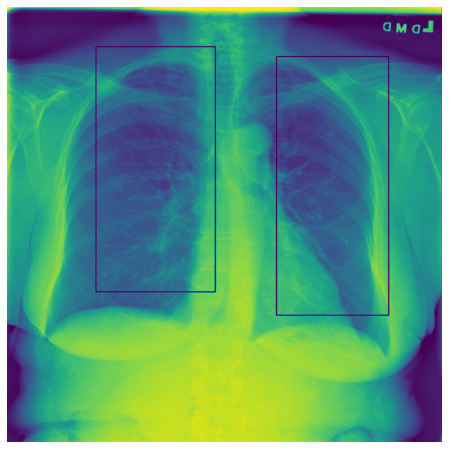

In [ ]:
from matplotlib import pyplot as plt

def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

name = '000e3a7d-c0ca-4349-bb26-5af2d8993c3d'        
        
test_df['PredictionString'] = test_df['PredictionString'].apply(lambda a: a.split(' ')).apply(lambda myList: [x for i, x in enumerate(myList) if i%5 !=0])
lst1 = test_df[test_df['image_id'] == name]['PredictionString'].values[0]
lst1 = list(map(int, lst1))     
lst1_n = list(chunks(lst1, 4))

sample = plt.imread(testDataDir + name + '.jpg')

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
for box in lst1_n:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2] + box[0], box[3] + box[1]),
                  (0, 0, 100), 2)
  
ax.set_axis_off()
ax.imshow(sample)